Link do notatnika: https://colab.research.google.com/drive/11IeSIfCIph7dxCvqlyZTEVKFuEfQTQa1?usp=sharing

---



In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

from sklearn.decomposition import PCA
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
iris_path = "/content/drive/MyDrive/Colab Notebooks/1 sem AI/ML/ML_l0/Iris.csv"
wine_path = "/content/drive/MyDrive/Colab Notebooks/1 sem AI/ML/ML_l0/wine.data"

y1 = "/content/drive/MyDrive/Colab Notebooks/1 sem AI/ML/ML_l1/data/1year.arff"
y2 = "/content/drive/MyDrive/Colab Notebooks/1 sem AI/ML/ML_l1/data/2year.arff"
y3 = "/content/drive/MyDrive/Colab Notebooks/1 sem AI/ML/ML_l1/data/3year.arff"
y4 = "/content/drive/MyDrive/Colab Notebooks/1 sem AI/ML/ML_l1/data/4year.arff"
y5 = "/content/drive/MyDrive/Colab Notebooks/1 sem AI/ML/ML_l1/data/5year.arff"

In [ ]:
def metrix(y_test, y_pred):
  acc= accuracy_score(y_test, y_pred)
  f1_s = f1_score(y_test, y_pred, average='macro')

  print(f'Accuracy: {acc}\nf1 score: {f1_s}')

  cm = confusion_matrix(y_test, y_pred)
  sns.heatmap(cm, annot=True)

param_grid = {
    'n_neighbors': np.arange(1, 16),
    'weights': ['uniform', 'distance'],  # równomierne, ważone, moje
    'p': [1, 2, 3, 4],  # 1->Manhattan, 2->Euklides, 3->Minkowski, 4->Czebyszew
}



---


# Iris

In [ ]:
iris = pd.read_csv(iris_path)
iris = iris.drop('Id', axis=1)  #usunięcie niepotrzebnego Id

In [ ]:
iris.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [ ]:
fig = px.scatter(iris, x = "SepalLengthCm", y = "SepalWidthCm", color = "Species",
                 width=700, height=400, title="Zależność długość i szerokości kielicha")
fig.show()

In [ ]:
pd.value_counts(iris['Species'])  #Sprawdzenie rozkładu klas

Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: Species, dtype: int64

In [ ]:
y = iris.pop('Species')
X = iris

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2,
                                                    random_state=1)

**KNN**

Accuracy: 0.9666666666666667
f1 score: 0.9665831244778613


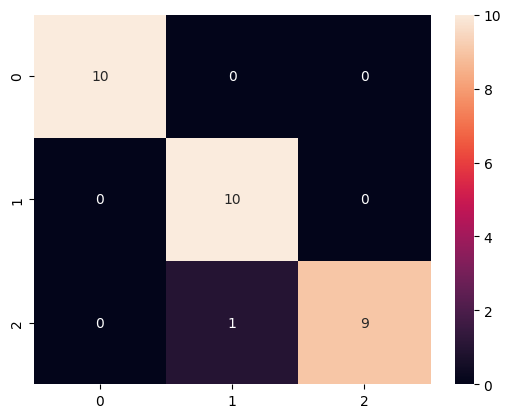

In [ ]:
# default params
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

metrix(y_test, y_pred)

In [ ]:
# crossvalidation
fold_sizes = np.arange(2,11)
results = {}
scr = []
for fold_size in fold_sizes:
  scores = cross_val_score(knn, X_train, y_train,
                           cv=fold_size, scoring='f1_macro')
  for score in scores:
    scr.append([score, fold_size])

  results[(fold_size)] = { 'f1_score': scores.mean()}

In [ ]:
print('Number of k-folds with scoring:')
pd.DataFrame(results)

Number of k-folds with scoring:


,2,3,4,5,6,7,8,9,10
f1_score,0.966646,0.966343,0.958271,0.966601,0.957526,0.957602,0.957912,0.957244,0.949471


In [ ]:
scored_df = pd.DataFrame(scr, columns=['score', 'kfold'])
fig = px.box(scored_df, x = 'kfold', y="score", title='Kfolds scores')
fig.show()

In [ ]:
# Stratified cros
results = {}
scr = []
for fold_size in fold_sizes:
  stratified_kfold = StratifiedKFold(n_splits=fold_size, shuffle=True)
  scores = cross_val_score(knn, X_train, y_train, cv=stratified_kfold,
                           scoring='f1_macro')
  for score in scores:
    scr.append([score, fold_size])

  results[(fold_size)] = { 'f1_score': scores.mean()}

In [ ]:
print('Number of k-folds with scoring:')
pd.DataFrame(results)

Number of k-folds with scoring:


,2,3,4,5,6,7,8,9,10
f1_score,0.95815,0.931929,0.941394,0.949869,0.949549,0.940693,0.949495,0.949984,0.940741


In [ ]:
scored_df = pd.DataFrame(scr, columns=['score', 'kfold'])
fig = px.box(scored_df, x = 'kfold', y="score", title='Kfolds scores for stratified kfold')
fig.show()

In [ ]:
def custom_weight(distances):
    weights = 1 / (distances + 0.1)
    return weights

grid_search = GridSearchCV(knn, param_grid, scoring='f1_macro', cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
                         'p': [1, 2, 3, 4],
                         'weights': ['uniform', 'distance']},
             scoring='f1_macro')

Najlepsze wartości hiperparametrów: {'n_neighbors': 3, 'p': 3, 'weights': 'uniform'}
z uzyskanym wynikiem: 0.9832679738562092
Wyniki na zbiorze testowym:

Accuracy: 0.9666666666666667
f1 score: 0.9665831244778613


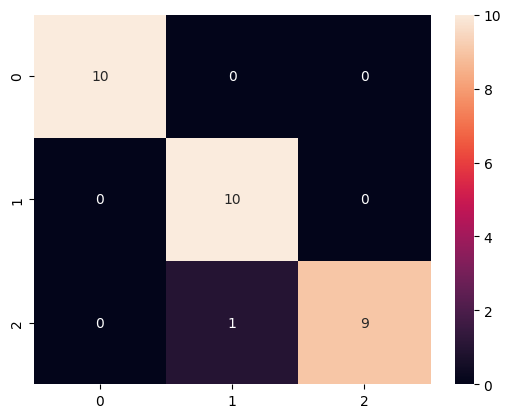

In [ ]:
print(f'Najlepsze wartości hiperparametrów: {grid_search.best_params_}\n\
z uzyskanym wynikiem: {grid_search.best_score_}')

y_preds = grid_search.predict(X_test)

print('Wyniki na zbiorze testowym:\n')
metrix(y_test, y_preds)

In [ ]:
cv_df = pd.DataFrame(grid_search.cv_results_)
cv_df.sort_values(by=['mean_test_score'], ascending=False).head(7)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_p,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
60,0.003102,0.000076,0.005932,0.000039,8,3,uniform,"{'n_neighbors': 8, 'p': 3, 'weights': 'uniform'}",0.95817,0.95817,1.0,1.00000,1.00000,0.983268,0.020492,1
20,0.002158,0.000075,0.004120,0.000267,3,3,uniform,"{'n_neighbors': 3, 'p': 3, 'weights': 'uniform'}",0.95817,0.95817,1.0,1.00000,1.00000,0.983268,0.020492,1
79,0.003134,0.000115,0.005113,0.000107,10,4,distance,"{'n_neighbors': 10, 'p': 4, 'weights': 'distan...",0.95817,1.00000,1.0,0.95817,1.00000,0.983268,0.020492,1
77,0.003087,0.000030,0.005170,0.000224,10,3,distance,"{'n_neighbors': 10, 'p': 3, 'weights': 'distan...",0.95817,1.00000,1.0,0.95817,1.00000,0.983268,0.020492,1
69,0.003101,0.000319,0.005653,0.001127,9,3,distance,"{'n_neighbors': 9, 'p': 3, 'weights': 'distance'}",0.95817,1.00000,1.0,1.00000,0.95817,0.983268,0.020492,1
68,0.003052,0.000102,0.006045,0.000353,9,3,uniform,"{'n_neighbors': 9, 'p': 3, 'weights': 'uniform'}",0.95817,1.00000,1.0,1.00000,0.95817,0.983268,0.020492,1
63,0.003353,0.000175,0.005633,0.000739,8,4,distance,"{'n_neighbors': 8, 'p': 4, 'weights': 'distance'}",0.95817,1.00000,1.0,0.95817,1.00000,0.983268,0.020492,1


In [ ]:
# testing n_neighbors
n_n = param_grid['n_neighbors']
results_n = []
scr = []
for n in n_n:
  knn = KNeighborsClassifier(n_neighbors=n)
  scores = cross_val_score(knn, X_train, y_train,
                           cv=5, scoring='f1_macro')
  results_n.append(scores.mean())
  for score in scores:
    scr.append([score, n])

In [ ]:
scored_df = pd.DataFrame(scr, columns=['score', 'n_neighbors'])
fig = px.box(scored_df, x = 'n_neighbors', y="score", title='n_neighbors scores')
fig.show()

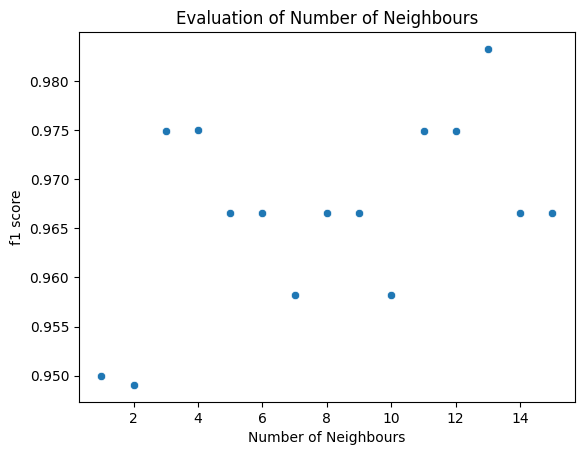

In [ ]:
sns.scatterplot(x=n_n, y=results_n)
plt.xlabel('Number of Neighbours')
plt.ylabel('f1 score')
plt.title('Evaluation of Number of Neighbours')
plt.show()

In [ ]:
# testing weights
weights = param_grid['weights']
results = []
scr = []
for w in weights:
  knn = KNeighborsClassifier(weights=w)
  scores = cross_val_score(knn, X_train, y_train,
                           cv=5, scoring='f1_macro')
  results.append(scores.mean())
  for score in scores:
    scr.append([score, w])

In [ ]:
scored_df = pd.DataFrame(scr, columns=['score', 'weights'])
fig = px.box(scored_df, x = 'weights', y="score", title='weights scores')
fig.show()

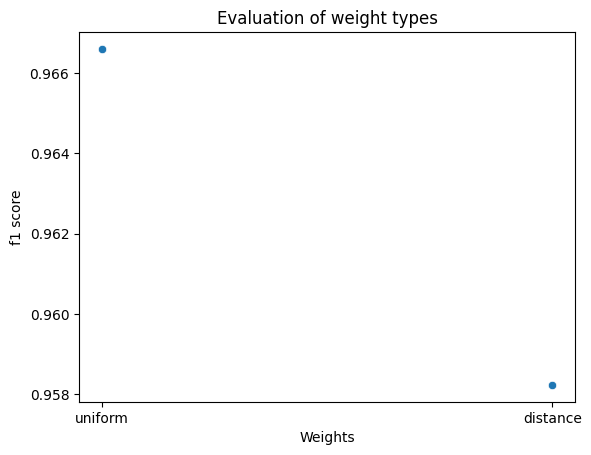

In [ ]:
sns.scatterplot(x=weights, y=results)
plt.xlabel('Weights')
plt.ylabel('f1 score')
plt.title('Evaluation of weight types')
plt.show()

In [ ]:
# testing Power parameters for the Minkowski metric
p = ['Manhattan', 'Euklides', 'Minkowski', 'Czebyszew']
m_m = param_grid['p']
results = []
scr = []
for m in m_m:
  knn = KNeighborsClassifier(p=m)
  scores = cross_val_score(knn, X_train, y_train,
                           cv=5, scoring='f1_macro')
  results.append(scores.mean())
  for score in scores:
    scr.append([score, p[m-1]])

In [ ]:
scored_df = pd.DataFrame(scr, columns=['score', 'Power parameter'])
fig = px.box(scored_df, x = 'Power parameter', y="score", title='Power parameter scores')
fig.show()

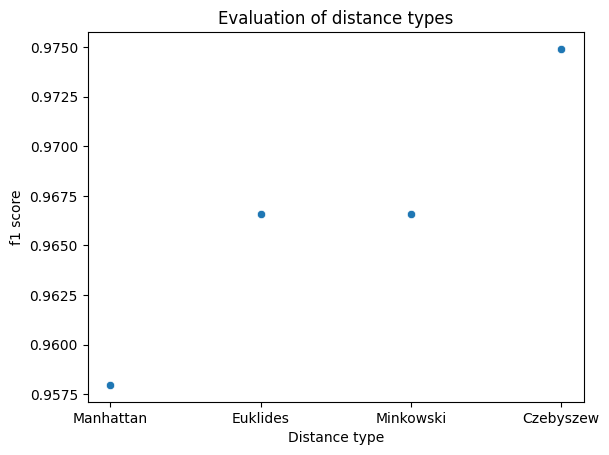

In [ ]:
sns.scatterplot(x=p, y=results)
plt.xlabel('Distance type')
plt.ylabel('f1 score')
plt.title('Evaluation of distance types')
plt.show()

# Wine

In [ ]:
wine = pd.read_csv(wine_path, header=None)
wine.columns = ['Quality', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash',
                'Magnesium', 'Total phenols', 'Flavanoids',
                'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity' ,
                'Hue', 'OD280/OD315 of diluted wines', 'Proline']

In [ ]:
wine.head()

,Quality,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [ ]:
pd.value_counts(wine['Quality'])  #Sprawdzenie rozkładu klas

2    71
1    59
3    48
Name: Quality, dtype: int64

In [ ]:
fig = px.scatter(wine, x = "Hue", y = "Alcohol", color = "Quality",
                 width=700, height=400, title="Zależność mocy trunku od jego odcienia")
fig.show()

In [ ]:
y = wine.pop('Quality')
X = wine

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2,
                                                    random_state=1)

KNN

Accuracy: 0.6666666666666666
f1 score: 0.6620370370370371


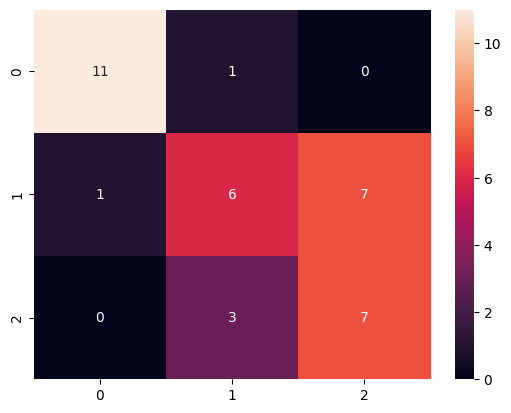

In [ ]:
# default params
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

metrix(y_test, y_pred)

In [ ]:
# pipeline ze skalowaniem wartości
pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])

Accuracy: 0.9722222222222222
f1 score: 0.9723691945914168


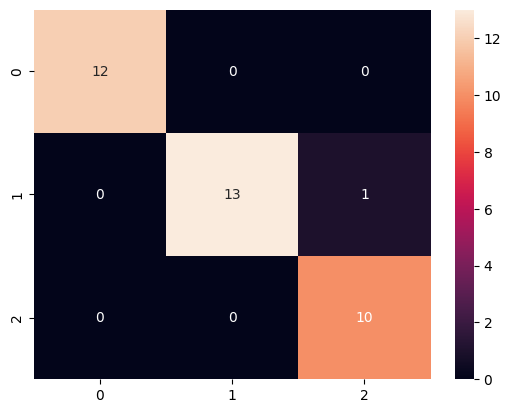

In [ ]:
# default params for scaled df
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

metrix(y_test, y_pred)

In [ ]:
# crossvalidation
fold_sizes = np.arange(2,11)
results = {}
scr = []
for fold_size in fold_sizes:
  scores = cross_val_score(pipe, X_train, y_train,
                           cv=fold_size, scoring='f1_macro')
  for score in scores:
    scr.append([score, fold_size])

  results[(fold_size)] = { 'f1_score': scores.mean()}

In [ ]:
print('Number of k-folds with scoring:')
pd.DataFrame(results)

Number of k-folds with scoring:


,2,3,4,5,6,7,8,9,10
f1_score,0.952072,0.957987,0.950976,0.949921,0.936739,0.934362,0.956985,0.952161,0.95899


In [ ]:
scored_df = pd.DataFrame(scr, columns=['score', 'kfold'])
fig = px.box(scored_df, x = 'kfold', y="score", title='Kfolds scores')
fig.show()

In [ ]:
# Stratified cros
results = {}
scr = []
for fold_size in fold_sizes:
  stratified_kfold = StratifiedKFold(n_splits=fold_size, shuffle=True)
  scores = cross_val_score(pipe, X_train, y_train, cv=stratified_kfold,
                           scoring='f1_macro')
  for score in scores:
    scr.append([score, fold_size])

  results[(fold_size)] = { 'f1_score': scores.mean()}

In [ ]:
print('Number of k-folds with scoring:')
pd.DataFrame(results)

Number of k-folds with scoring:


,2,3,4,5,6,7,8,9,10
f1_score,0.944875,0.958312,0.936927,0.922172,0.951337,0.967236,0.935706,0.95016,0.951619


In [ ]:
scored_df = pd.DataFrame(scr, columns=['score', 'kfold'])
fig = px.box(scored_df, x = 'kfold', y="score", title='Kfolds scores for stratified folds')
fig.show()

In [ ]:
param_grid = {
    'knn__n_neighbors': np.arange(1, 16),
    'knn__weights': ['uniform', 'distance'],  # równomierne, ważone, moje
    'knn__p': [1, 2, 3, 4],  # 1->Manhattan, 2->Euklides, 3->Minkowski, 4->Czebyszew
}

grid_search = GridSearchCV(pipe, param_grid, scoring='f1_macro', cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
                         'knn__p': [1, 2, 3, 4],
                         'knn__weights': ['uniform', 'distance']},
             scoring='f1_macro')

Najlepsze wartości hiperparametrów: {'knn__n_neighbors': 11, 'knn__p': 1, 'knn__weights': 'uniform'}
z uzyskanym wynikiem: 0.9795537864268514
Accuracy: 0.9722222222222222
f1 score: 0.9722633744855967


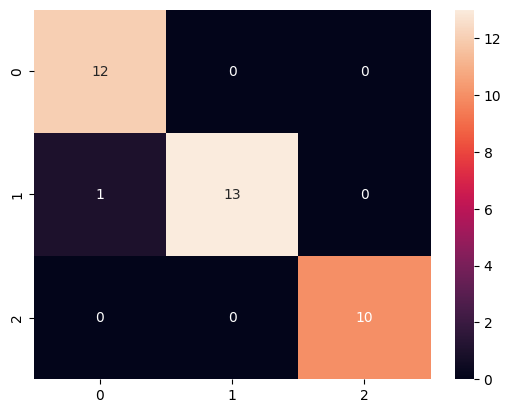

In [ ]:
print(f'Najlepsze wartości hiperparametrów: {grid_search.best_params_}\n\
z uzyskanym wynikiem: {grid_search.best_score_}')

y_preds = grid_search.predict(X_test)
metrix(y_test, y_preds)

In [ ]:
cv_df = pd.DataFrame(grid_search.cv_results_)
cv_df.sort_values(by=['mean_test_score'], ascending=False).head(7)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__n_neighbors,param_knn__p,param_knn__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
80,0.007129,0.003598,0.006086,0.001489,11,1,uniform,"{'knn__n_neighbors': 11, 'knn__p': 1, 'knn__we...",1.0,1.0,0.929515,0.968254,1.000000,0.979554,0.027877,1
81,0.006007,0.001327,0.004704,0.000426,11,1,distance,"{'knn__n_neighbors': 11, 'knn__p': 1, 'knn__we...",1.0,1.0,0.929515,0.968254,1.000000,0.979554,0.027877,1
64,0.007228,0.000726,0.009441,0.002827,9,1,uniform,"{'knn__n_neighbors': 9, 'knn__p': 1, 'knn__wei...",1.0,1.0,0.929515,0.968254,0.968254,0.973205,0.026053,3
65,0.007253,0.000388,0.007237,0.001581,9,1,distance,"{'knn__n_neighbors': 9, 'knn__p': 1, 'knn__wei...",1.0,1.0,0.929515,0.968254,0.968254,0.973205,0.026053,3
73,0.004425,0.000291,0.003703,0.000071,10,1,distance,"{'knn__n_neighbors': 10, 'knn__p': 1, 'knn__we...",1.0,1.0,0.929515,0.968254,0.968254,0.973205,0.026053,3
89,0.004827,0.000358,0.004017,0.000236,12,1,distance,"{'knn__n_neighbors': 12, 'knn__p': 1, 'knn__we...",1.0,1.0,0.929515,0.968254,0.968254,0.973205,0.026053,3
105,0.004353,0.000111,0.003871,0.000115,14,1,distance,"{'knn__n_neighbors': 14, 'knn__p': 1, 'knn__we...",1.0,1.0,0.929515,0.968254,0.968254,0.973205,0.026053,3


In [ ]:
# testing n_neighbors
n_n = param_grid['knn__n_neighbors']
results_n = []
scr = []
for n in n_n:
  pipe.set_params(knn__n_neighbors=n)
  scores = cross_val_score(pipe, X_train, y_train,
                           cv=5, scoring='f1_macro')
  results_n.append(scores.mean())
  for score in scores:
    scr.append([score, n])

In [ ]:
scored_df = pd.DataFrame(scr, columns=['score', 'n_neighbors'])
fig = px.box(scored_df, x = 'n_neighbors', y="score", title='n_neighbors scores')
fig.show()

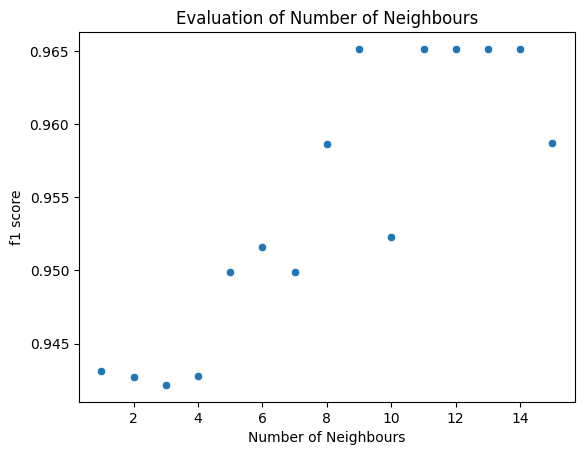

In [ ]:
sns.scatterplot(x=n_n, y=results_n)
plt.xlabel('Number of Neighbours')
plt.ylabel('f1 score')
plt.title('Evaluation of Number of Neighbours')
plt.show()

In [ ]:
# testing weights
weights = param_grid['knn__weights']
results = []
scr = []
for w in weights:
  pipe.set_params(knn__weights=w)
  scores = cross_val_score(pipe, X_train, y_train,
                           cv=5, scoring='f1_macro')
  results.append(scores.mean())
  for score in scores:
    scr.append([score, w])

In [ ]:
scored_df = pd.DataFrame(scr, columns=['score', 'weights'])
fig = px.box(scored_df, x = 'weights', y="score", title='weights scores')
fig.show()

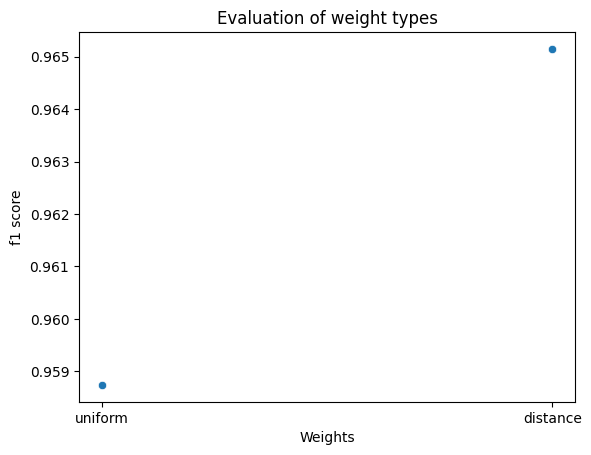

In [ ]:
sns.scatterplot(x=weights, y=results)
plt.xlabel('Weights')
plt.ylabel('f1 score')
plt.title('Evaluation of weight types')
plt.show()

In [ ]:
# testing Power parameters for the Minkowski metric
p = ['Manhattan', 'Euklides', 'Minkowski', 'Czebyszew']
m_m = param_grid['knn__p']
results = []
scr = []
for m in m_m:
  pipe.set_params(knn__p=m)
  scores = cross_val_score(pipe, X_train, y_train,
                           cv=5, scoring='f1_macro')
  results.append(scores.mean())
  for score in scores:
    scr.append([score, p[m-1]])

In [ ]:
scored_df = pd.DataFrame(scr, columns=['score', 'Power parameter'])
fig = px.box(scored_df, x = 'Power parameter', y="score", title='Power parameter scores')
fig.show()

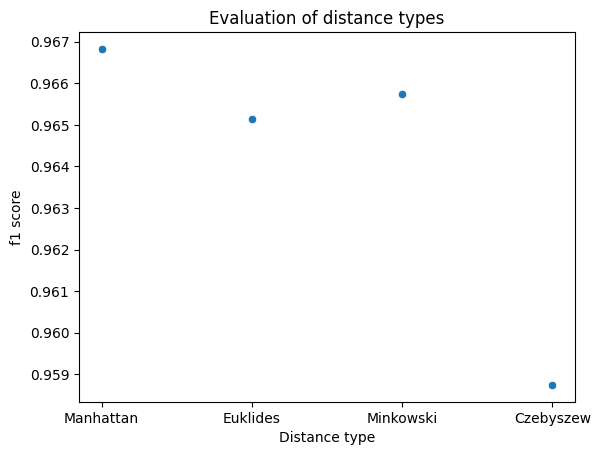

In [ ]:
sns.scatterplot(x=p, y=results)
plt.xlabel('Distance type')
plt.ylabel('f1 score')
plt.title('Evaluation of distance types')
plt.show()

In [ ]:
#PCA
# pipeline ze skalowaniem wartości i PCA
pipe = Pipeline([('scaler', StandardScaler()), ('pca',PCA()), ('knn', KNeighborsClassifier())])

param_grid_pca = {
    'knn__n_neighbors': np.arange(1, 16),
    'knn__weights': ['uniform', 'distance'],  # równomierne, ważone, moje
    'knn__p': [1, 2, 3, 4],  # 1->Manhattan, 2->Euklides, 3->Minkowski, 4->Czebyszew
    'pca__n_components': [2,3,4,5],
}


In [ ]:
grid_search = GridSearchCV(pipe, param_grid_pca, scoring='f1_macro', cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
                         'knn__p': [1, 2, 3, 4],
                         'knn__weights': ['uniform', 'distance'],
                         'pca__n_components': [2, 3, 4, 5]},
             scoring='f1_macro')

Najlepsze wartości hiperparametrów z pca: {'knn__n_neighbors': 14, 'knn__p': 4, 'knn__weights': 'distance', 'pca__n_components': 4}
z uzyskanym wynikiem: 0.9795537864268514
Accuracy: 0.9444444444444444
f1 score: 0.9444444444444444


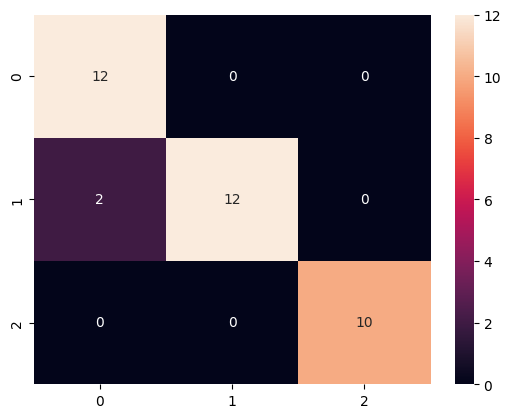

In [ ]:
print(f'Najlepsze wartości hiperparametrów z pca: {grid_search.best_params_}\n\
z uzyskanym wynikiem: {grid_search.best_score_}')

y_preds = grid_search.predict(X_test)
metrix(y_test, y_preds)

# PCB

In [ ]:
#Ładowanie 5 zbiorów do DF
from scipy.io.arff import loadarff

y1_raw = loadarff(y1)
bank_y1 = pd.DataFrame(y1_raw[0])

y2_raw = loadarff(y2)
bank_y2 = pd.DataFrame(y2_raw[0])

y3_raw = loadarff(y3)
bank_y3 = pd.DataFrame(y3_raw[0])

y4_raw = loadarff(y4)
bank_y4 = pd.DataFrame(y4_raw[0])

y5_raw = loadarff(y5)
bank_y5 = pd.DataFrame(y5_raw[0])

In [ ]:
# Łączenie w 1 DF
frames = [bank_y1, bank_y2, bank_y3, bank_y4, bank_y5]
bank_all = pd.concat(frames, ignore_index=True)

In [ ]:
bank_all = bank_all.drop(columns=['Attr37'])

In [ ]:
encoder = OrdinalEncoder()

bank_all["class"] = encoder.fit_transform(bank_all[["class"]])

In [ ]:
bank_all.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,0.0
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,0.0
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,0.0
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,0.0
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,0.0


In [ ]:
y = bank_all.pop('class')
X = bank_all

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2,
                                                    random_state=1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

pipe = Pipeline([('imputer', SimpleImputer(strategy='mean')),
                 ('knn', KNeighborsClassifier())])

Accuracy: 0.9513880889298468
f1 score: 0.5671664469051433


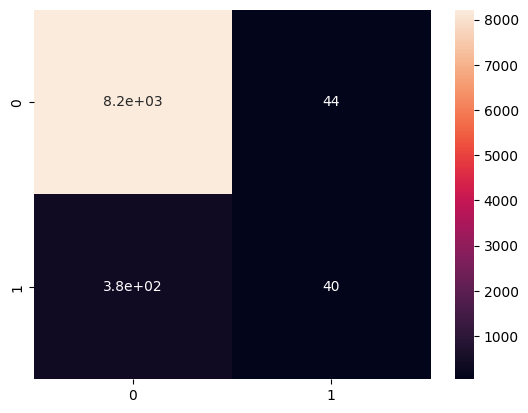

In [ ]:
# default params
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

metrix(y_test, y_pred)

In [ ]:
# crossvalidation
fold_sizes = np.arange(2,11)
results = {}
scr = []
for fold_size in fold_sizes:
  scores = cross_val_score(pipe, X_train, y_train,
                           cv=fold_size, scoring='f1_macro')
  for score in scores:
    scr.append([score, fold_size])

  results[(fold_size)] = { 'f1_score': scores.mean()}

In [ ]:
print('Number of k-folds with scoring:')
pd.DataFrame(results)

Number of k-folds with scoring:


,2,3,4,5,6,7,8,9,10
f1_score,0.550149,0.561671,0.564579,0.567617,0.563358,0.562289,0.565056,0.564928,0.566296


In [ ]:
scored_df = pd.DataFrame(scr, columns=['score', 'kfold'])
fig = px.box(scored_df, x = 'kfold', y="score", title='Kfolds scores')
fig.show()

In [ ]:
# Stratified cros
results = {}
scr = []
for fold_size in fold_sizes:
  stratified_kfold = StratifiedKFold(n_splits=fold_size, shuffle=True)
  scores = cross_val_score(pipe.cuda(), X_train, y_train, cv=stratified_kfold,
                           scoring='f1_macro')
  for score in scores:
    scr.append([score, fold_size])

  results[(fold_size)] = { 'f1_score': scores.mean()}

In [ ]:
print('Number of k-folds with scoring:')
pd.DataFrame(results)

Number of k-folds with scoring:


,2,3,4,5,6,7,8,9,10
f1_score,0.549754,0.555662,0.563949,0.558573,0.564683,0.56491,0.56155,0.56797,0.565388


In [ ]:
scored_df = pd.DataFrame(scr, columns=['score', 'kfold'])
fig = px.box(scored_df, x = 'kfold', y="score", title='Kfolds scores for stratified folds')
fig.show()

In [ ]:
param_grid = {
    'knn__n_neighbors': np.arange(1, 16),
    'knn__weights': ['uniform', 'distance'],  # równomierne, ważone, moje
    'knn__p': [1, 2, 3, 4],  # 1->Manhattan, 2->Euklides, 3->Minkowski, 4->Czebyszew
}

In [ ]:
# testing n_neighbors
n_n = param_grid['knn__n_neighbors']
results_n = []
scr = []
for n in n_n:
  pipe.set_params(knn__n_neighbors=n)
  scores = cross_val_score(pipe, X_train, y_train,
                           cv=5, scoring='f1_macro')
  results_n.append(scores.mean())
  for score in scores:
    scr.append([score, n])

In [ ]:
scored_df = pd.DataFrame(scr, columns=['score', 'n_neighbors'])
fig = px.box(scored_df, x = 'n_neighbors', y="score", title='n_neighbors scores')
fig.show()

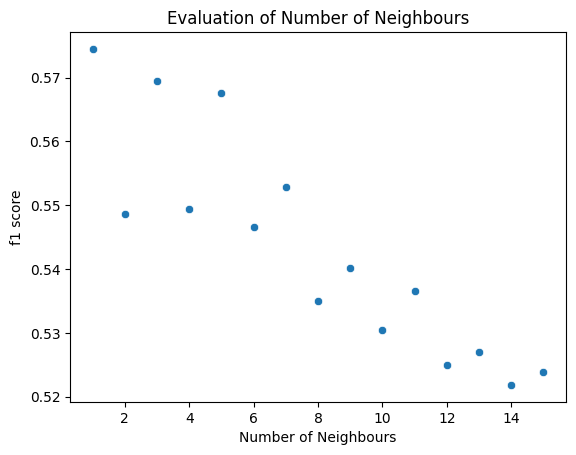

In [ ]:
sns.scatterplot(x=n_n, y=results_n)
plt.xlabel('Number of Neighbours')
plt.ylabel('f1 score')
plt.title('Evaluation of Number of Neighbours')
plt.show()

In [ ]:
# testing weights
weights = param_grid['knn__weights']
results = []
scr = []
for w in weights:
  pipe.set_params(knn__weights=w)
  scores = cross_val_score(pipe, X_train, y_train,
                           cv=5, scoring='f1_macro')
  results.append(scores.mean())
  for score in scores:
    scr.append([score, w])

In [ ]:
scored_df = pd.DataFrame(scr, columns=['score', 'weights'])
fig = px.box(scored_df, x = 'weights', y="score", title='weights scores')
fig.show()

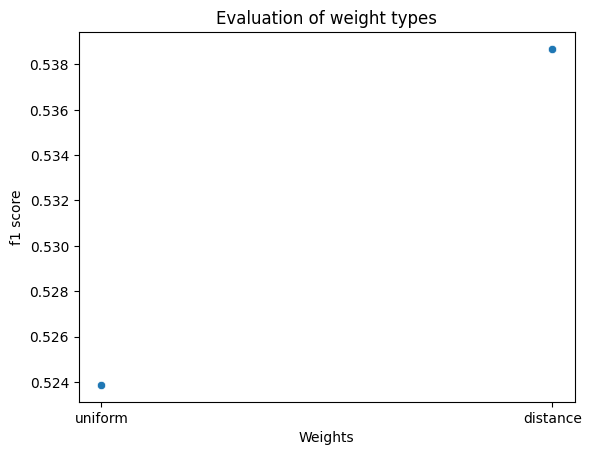

In [ ]:
sns.scatterplot(x=weights, y=results)
plt.xlabel('Weights')
plt.ylabel('f1 score')
plt.title('Evaluation of weight types')
plt.show()

In [ ]:
# testing Power parameters for the Minkowski metric
p = ['Manhattan', 'Euklides', 'Minkowski', 'Czebyszew']
m_m = param_grid['knn__p']
results = []
scr = []
for m in m_m:
  pipe.set_params(knn__p=m)
  scores = cross_val_score(pipe, X_train, y_train,
                           cv=5, scoring='f1_macro')
  results.append(scores.mean())
  for score in scores:
    scr.append([score, p[m-1]])

In [ ]:
scored_df = pd.DataFrame(scr, columns=['score', 'Power parameter'])
fig = px.box(scored_df, x = 'Power parameter', y="score", title='Power parameter scores')
fig.show()

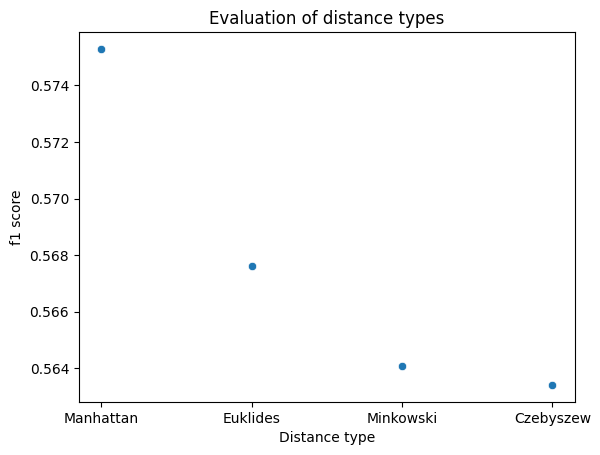

In [ ]:
sns.scatterplot(x=p, y=results)
plt.xlabel('Distance type')
plt.ylabel('f1 score')
plt.title('Evaluation of distance types')
plt.show()

In [ ]:
# grid z najlpszymi hiperparametrami
param_grid_best = {
    'knn__n_neighbors': [1, 3, 5],
    'knn__weights': ['distance'],  # ważone
    'knn__p': [1],  # 1->Manhattan,
}

In [ ]:
grid_search = GridSearchCV(pipe, param_grid_best, scoring='f1_macro', cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('knn', KNeighborsClassifier(p=4))]),
             param_grid={'knn__n_neighbors': [1, 3, 5], 'knn__p': [1],
                         'knn__weights': ['distance']},
             scoring='f1_macro')

Najlepsze wartości hiperparametrów: {'knn__n_neighbors': 3, 'knn__p': 1, 'knn__weights': 'distance'}
z uzyskanym wynikiem: 0.5813386949986648
Accuracy: 0.9407902315401452
f1 score: 0.5792737615166094


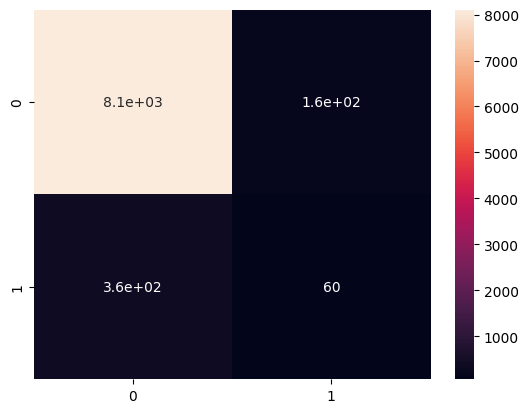

In [ ]:
print(f'Najlepsze wartości hiperparametrów: {grid_search.best_params_}\n\
z uzyskanym wynikiem: {grid_search.best_score_}')

y_preds = grid_search.predict(X_test)
metrix(y_test, y_preds)

In [ ]:
cv_df = pd.DataFrame(grid_search.cv_results_)
cv_df.sort_values(by=['mean_test_score'], ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__n_neighbors,param_knn__p,param_knn__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.051196,0.007723,17.551616,0.577893,3,1,distance,"{'knn__n_neighbors': 3, 'knn__p': 1, 'knn__wei...",0.591106,0.573400,0.565436,0.581848,0.594902,0.581339,0.010914,1
0,0.058591,0.012438,17.570949,0.611690,1,1,distance,"{'knn__n_neighbors': 1, 'knn__p': 1, 'knn__wei...",0.585414,0.565614,0.575592,0.586994,0.587022,0.580127,0.008412,2
2,0.052206,0.007720,17.552033,0.885859,5,1,distance,"{'knn__n_neighbors': 5, 'knn__p': 1, 'knn__wei...",0.582014,0.562576,0.565354,0.578018,0.587983,0.575189,0.009737,3


In [ ]:
# + standard scaler
pipe = Pipeline([('imputer', SimpleImputer(strategy='mean')),
                 ('scaler', StandardScaler()),
                 ('knn', KNeighborsClassifier())])

Accuracy: 0.9432093076834466
f1 score: 0.5667978197234075


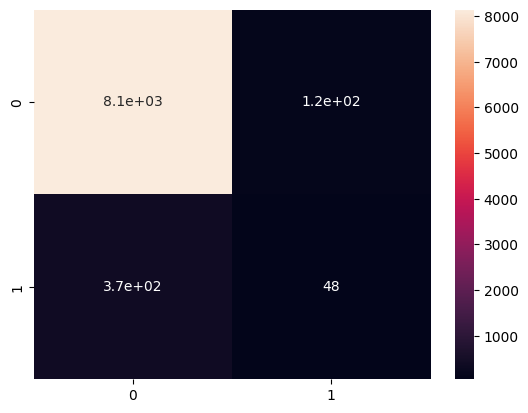

In [ ]:
pipe.set_params(knn__n_neighbors=3, knn__p=1, knn__weights='distance')
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

metrix(y_test, y_pred)

Skalowane **wartości**

In [ ]:
#PCA
# pipeline ze skalowaniem wartości i PCA
pipe = Pipeline([('imputer', SimpleImputer(strategy='mean')),
                 ('pca',PCA()),
                 ('knn', KNeighborsClassifier())])

param_grid_pca = {
    'knn__n_neighbors': [3],
    'knn__weights': ['distance'],  # równomierne, ważone, moje
    'knn__p': [1],  # 1->Manhattan, 2->Euklides, 3->Minkowski, 4->Czebyszew
    'pca__n_components': [17,20,22],
}


In [ ]:
grid_search = GridSearchCV(pipe, param_grid_pca, scoring='f1_macro', cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('pca', PCA()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [3], 'knn__p': [1],
                         'knn__weights': ['distance'],
                         'pca__n_components': [17, 20, 22]},
             scoring='f1_macro')

Najlepsze wartości hiperparametrów z pca: {'knn__n_neighbors': 3, 'knn__p': 1, 'knn__weights': 'distance', 'pca__n_components': 20}
z uzyskanym wynikiem: 0.5807186619531388
Accuracy: 0.9398686787236493
f1 score: 0.5740181933448997


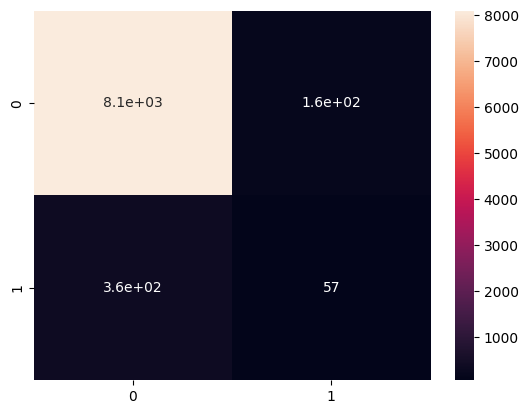

In [ ]:
print(f'Najlepsze wartości hiperparametrów z pca: {grid_search.best_params_}\n\
z uzyskanym wynikiem: {grid_search.best_score_}')

y_preds = grid_search.predict(X_test)
metrix(y_test, y_preds)